# Import libraries

In [1]:
%matplotlib inline

import os
import sys
import shutil
print("Python:", sys.version)

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
print("NumPy version:", np.__version__)

import scipy
from scipy.io import loadmat
print("SciPy version:", scipy.__version__)

import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib version:", matplotlib.__version__)

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("scikit-learn version:", sklearn.__version__)

np.random.seed(99)
tf.random.set_seed(99)

Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
TensorFlow version: 2.18.0
Keras version: 3.8.0
NumPy version: 1.26.4
SciPy version: 1.13.1
Matplotlib version: 3.10.0
scikit-learn version: 1.6.1


# Download and load the SVHN dataset

In [2]:
TRAIN_DATASET_PATH = "dataset/train_32x32.mat"
TEST_DATASET_PATH = "dataset/test_32x32.mat"

In [3]:
if not os.path.isdir("dataset"):
    os.makedirs("dataset")

if not os.path.isfile(TRAIN_DATASET_PATH):
    download_location = tf.keras.utils.get_file(origin=r"http://ufldl.stanford.edu/housenumbers/train_32x32.mat")
    shutil.move(download_location, TRAIN_DATASET_PATH)

if not os.path.isfile(TEST_DATASET_PATH):
    download_location = tf.keras.utils.get_file(origin=r"http://ufldl.stanford.edu/housenumbers/test_32x32.mat")
    shutil.move(download_location, TEST_DATASET_PATH)

In [4]:
train_dataset = loadmat(TRAIN_DATASET_PATH)
X_train = train_dataset["X"]
y_train = train_dataset["y"]
X_train = X_train.astype("float") / 255
X_train = np.moveaxis(X_train, -1, 0)

y_train[np.where(y_train == 10)] = 0
y_train = keras.utils.to_categorical(y_train, 10)

In [5]:
X_train.shape

(73257, 32, 32, 3)

In [6]:
y_train.shape

(73257, 10)

In [7]:
test_dataset = loadmat(TEST_DATASET_PATH)
X_test = test_dataset["X"]
y_test = test_dataset["y"]
X_test = X_test.astype("float") / 255
X_test = np.moveaxis(X_test, -1, 0)

y_test[np.where(y_test == 10)] = 0
y_test = keras.utils.to_categorical(y_test, 10)

In [8]:
X_test.shape

(26032, 32, 32, 3)

In [9]:
y_test.shape

(26032, 10)

# Create model

In [10]:
# AlexNet architecture

model = keras.Sequential([
    Input(shape=(32, 32, 3)),

    Conv2D(32, (5, 5), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),
    # BatchNormalization(),

    Conv2D(32, (3, 3), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),
    # BatchNormalization(),

    Conv2D(64, (3, 3), activation="relu", padding="valid"),
    Conv2D(64, (1, 1), activation="relu", padding="valid"),
    Conv2D(128, (1, 1), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    # Dropout(0.5),

    Dense(10, activation="softmax")
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,786 (842.91 KB)

 Trainable params: 215,786 (842.91 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [12]:
best_model_saving_callback = ModelCheckpoint(filepath="Best Model.keras", monitor="val_accuracy", mode="max", save_best_only=True)

In [13]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, callbacks=[best_model_saving_callback])

Epoch 1/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.4548 - loss: 1.5612 - val_accuracy: 0.8290 - val_loss: 0.5493
Epoch 2/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8397 - loss: 0.5205 - val_accuracy: 0.8539 - val_loss: 0.4828
Epoch 3/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8686 - loss: 0.4303 - val_accuracy: 0.8550 - val_loss: 0.4752
Epoch 4/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8828 - loss: 0.3849 - val_accuracy: 0.8657 - val_loss: 0.4677
Epoch 5/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8956 - loss: 0.3524 - val_accuracy: 0.8774 - val_loss: 0.4067
Epoch 6/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9010 - loss: 0.3259 - val_accuracy: 0.8930 - val_loss: 0.3759
Epoch 7/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9079 - loss: 0.3022 - val_accuracy: 0.8940 - val_loss: 0.3742
Epoch 8/20
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9138 - loss: 0.285

In [15]:
# Save fully trained model and load the best model for further evaluation cells.
fully_trained_model = model
model = tf.keras.models.load_model("Best Model.keras")

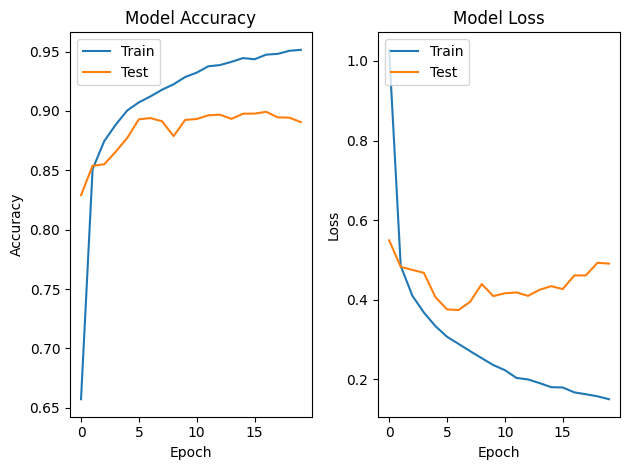

In [16]:
fig, axis = plt.subplots(1, 2)

axis[0].plot(history.history["accuracy"])
axis[0].plot(history.history["val_accuracy"])
axis[0].set_title("Model Accuracy")
axis[0].set_ylabel("Accuracy")
axis[0].set_xlabel("Epoch")
axis[0].legend(["Train", "Test"], loc="upper left")

# summarize history for loss
axis[1].plot(history.history["loss"])
axis[1].plot(history.history["val_loss"])
axis[1].set_title("Model Loss")
axis[1].set_ylabel("Loss")
axis[1].set_xlabel("Epoch")
axis[1].legend(["Train", "Test"], loc="upper left")

fig.tight_layout()
plt.show()

# Model Accuracy

In [17]:
d = model.evaluate(X_test, y_test, return_dict=True)
model_accuracy_truncated = int(d["accuracy"] * 100 * 100) / 100
d

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8904 - loss: 0.5365


{'accuracy': 0.8938997983932495, 'loss': 0.5118170976638794}

In [18]:
y_pred = model.predict(X_test)

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [19]:
model.compute_metrics(X_test, y_test, y_pred)

{'accuracy': 0.8938997983932495, 'loss': 0.5118170976638794}

In [20]:
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred.argmax(axis=-1), normalize="true")

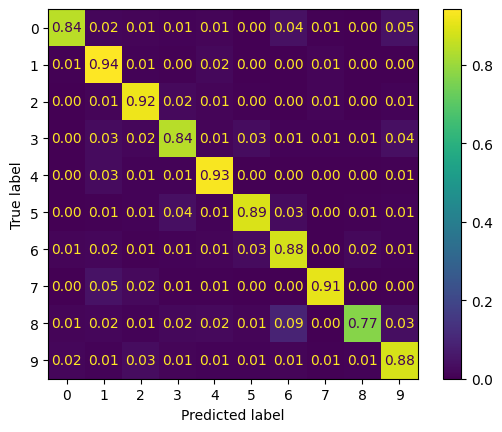

In [21]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=-1), y_pred.argmax(axis=-1), normalize="true", values_format=".2f")

# Save model

In [22]:
model.save(f"Colab AlexNet {model_accuracy_truncated}.keras")

In [23]:
# Accuracy over 5 runs.
# 89.38
#
#
#
#
# Average: .

# Load model for inference

In [24]:
# model = tf.keras.models.load_model("Colab SVHN AlexNet.keras")

In [25]:
# model.evaluate(X_test, y_test, return_dict=True)